In [1]:
from dataclasses import dataclass, field
from functools import reduce
from itertools import product

import igraph
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sp
import pandas as pd
import pynauty
from scipy.linalg import ishermitian
from scipy.sparse.csgraph import connected_components
from sympy.combinatorics import Permutation, PermutationGroup

from qlinks.model.aklt_model import AKLTModel
from utils import setup_igraph

np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", None)

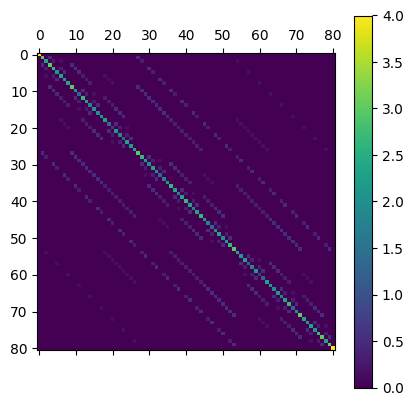

In [15]:
model = AKLTModel(4, periodic=True)
mat = model.hamiltonian.toarray()
assert ishermitian(mat)

evals, evecs = np.linalg.eigh(mat)

plt.matshow(mat)
plt.colorbar()

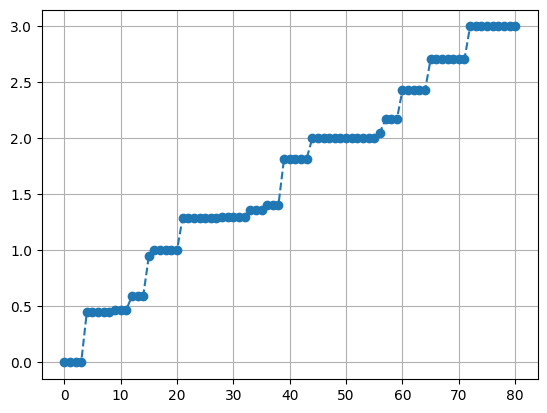

In [10]:
plt.plot(evals, linestyle="--", marker="o")
plt.grid()

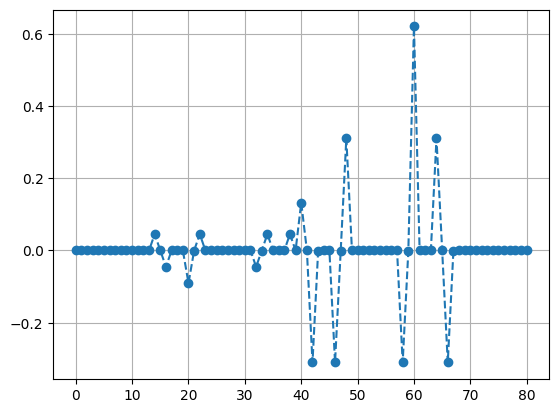

In [11]:
plt.plot(evecs[:, 0], linestyle="--", marker="o")
plt.grid()

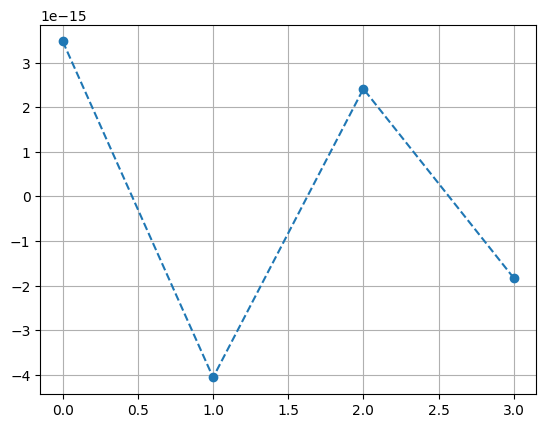

In [8]:
sx = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
sz = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]])
local_sz = np.array(
    [
        evecs[:, 0].T @ reduce(np.kron, [np.eye(3 ** site), sx, np.eye(3** (model.n - 1 - site))]) @ evecs[:, 0]
        for site in range(model.n)
    ]
)
plt.plot(local_sz, linestyle="--", marker="o")
plt.grid()

In [8]:
pd.DataFrame.from_dict(
    {i: j for i, j in enumerate(product([1, 0, -1], repeat=model.n))}, orient="index"
)

,0,1,2,3
0,1,1,1,1
1,1,1,1,0
2,1,1,1,-1
3,1,1,0,1
4,1,1,0,0
5,1,1,0,-1
6,1,1,-1,1
7,1,1,-1,0
8,1,1,-1,-1
9,1,0,1,1


In [16]:
g = nx.from_scipy_sparse_array(model.kinetic_term)
ig = igraph.Graph.from_networkx(g)

ntg = pynauty.Graph(
    ig.vcount(),
    directed=True,
    adjacency_dict=nx.to_dict_of_lists(g),
)
aut_gp = pynauty.autgrp(ntg)[0]

perm_gp = PermutationGroup([Permutation(p) for p in aut_gp])

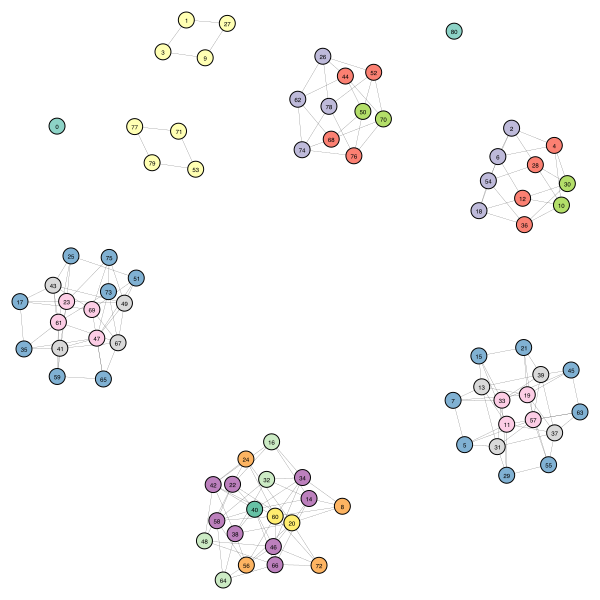

In [17]:
g = nx.from_scipy_sparse_array(model.kinetic_term)

highlight = [
    # np.where(np.abs(evecs[:, 231]) > 1e-6)[0],
]
# highlight = list(aut.degree_partition.values())
highlight = perm_gp.orbits()
# highlight = list(nx.bipartite.sets(g))

# highlight_color = list(mcolors.TABLEAU_COLORS.values())
# highlight_color = list(mcolors.CSS4_COLORS.values())
cmap = plt.get_cmap('Set3')
highlight_color = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
cmap = plt.get_cmap('Set2')
highlight_color += [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
highlight_color *= 2000
# highlight_color = [
#     "dimgray",
#     "whitesmoke",
#     "deepskyblue",
#     "yellowgreen",
#     "aqua",
#     "pink",
#     "tomato",
#     "royalblue",
#     "blueviolet",
#     "cornflowerblue",
#     "limegreen",
# ]

ig = setup_igraph(g, highlight, highlight_color)

degree = np.array(list(dict(g.degree).values()))
# (bipartite, types) = ig.is_bipartite(return_types=True)
# nodes = [int(n) for n in list(sub_sub_ig.vs["label"])]
# outer_boundary = list(nx.node_boundary(g, nodes))
# sub_ig = ig.induced_subgraph(np.append(nodes, outer_boundary))

# sub_ig = ig.induced_subgraph(np.where(degree == 8)[0])
# fig, ax = plt.subplots(figsize=(6, 6), facecolor="white")
igraph.plot(
    ig,
    # layout=ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=16,
    vertex_label_size=6,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_color="darkgray",
    # target="xy_graph_pbc_4.svg"
)

In [18]:
sub_components = ig.connected_components(mode="weak")

for i, c in enumerate(sub_components):
    mat = nx.to_numpy_array(ig.subgraph(c).to_networkx())
    # print(repr(mat))
    print(i, mat.shape[0], mat.shape[0] - np.linalg.matrix_rank(mat), nx.is_bipartite(ig.subgraph(c).to_networkx()))

0 1 1 True
1 4 2 True
2 10 2 False
3 16 0 False
4 19 4 False
5 16 0 False
6 10 2 False
7 4 2 True
8 1 1 True


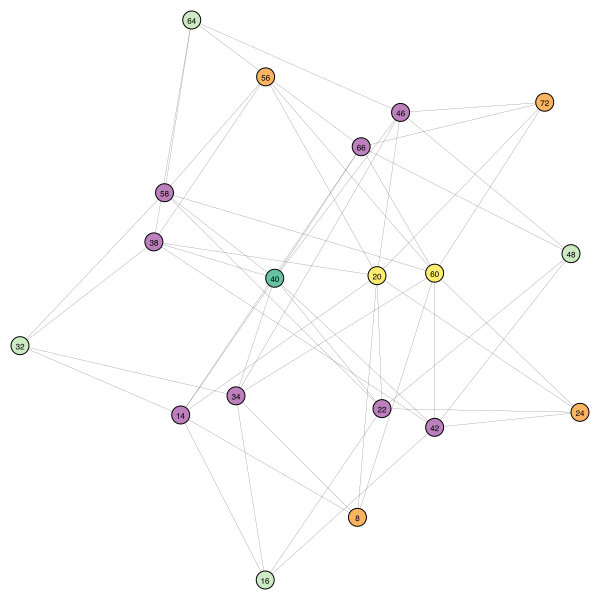

In [19]:
sub_ig = ig.subgraph(sub_components[4])

igraph.plot(
    sub_ig,
    # layout=sub_ig.layout_fruchterman_reingold(),
    # layout=sub_ig.layout_kamada_kawai(),
    # layout=ig.layout_reingold_tilford(root=[0, 25, 50, 75]),
    # layout=ig.layout_bipartite(types=types),
    vertex_size=18,
    vertex_label_size=8,
    # vertex_label_dist=1.5,
    edge_width=0.2,
    # edge_curved=0.1,
    # edge_color="darkgray",
    # bbox=(200,300),
    # target="xy_graph_pbc_5_sz-2.svg"
)

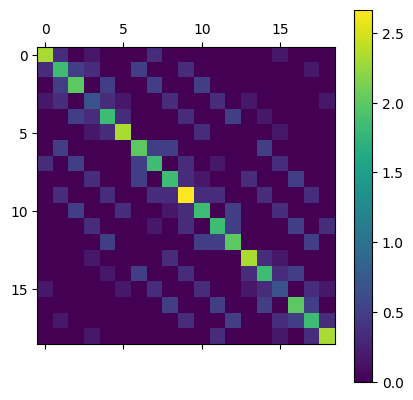

In [85]:
plt.matshow(nx.to_numpy_array(sub_ig.to_networkx()))
plt.colorbar()

In [87]:
np.diag(nx.to_numpy_array(sub_ig.to_networkx()))

array([2.33333333, 1.83333333, 2.        , 0.66666667, 1.83333333,
       2.33333333, 2.        , 1.83333333, 1.83333333, 2.66666667,
       1.83333333, 1.83333333, 2.        , 2.33333333, 1.83333333,
       0.66666667, 2.        , 1.83333333, 2.33333333])